In [7]:
import sys
!{sys.executable} -m pip install deap

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

from deap import base, creator, tools, algorithms
import random

# Load the data
data = pd.read_csv('equinox.csv')

# Convert 'bugs' column to binary (assuming 0 means no bug, and >0 means there's a bug)
data['bugs_binary'] = data['bugs'].apply(lambda x: 1 if x > 0 else 0)

# Pre-process the data
columns_to_drop = ['classname', 'bugs', 'nonTrivialBugs', 'majorBugs', 'criticalBugs', 'highPriorityBugs', 'bugs_binary']
X = data.drop(columns=columns_to_drop)
y = data['bugs_binary']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# There is no built-in package for ACO, here is the implementation:
class ACO:
    def __init__(self, n_features, n_ants, n_iterations, evaporation_rate, alpha, beta, seed=None):
        self.n_features = n_features
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.evaporation_rate = evaporation_rate
        self.alpha = alpha
        self.beta = beta
        self.pheromone = np.ones(n_features) / n_features
        if seed:
            random.seed(seed)
            np.random.seed(seed)

    def _select_features(self, feature_prob):
        features = []
        for i, prob in enumerate(feature_prob):
            if random.random() < prob:
                features.append(i)
        return features

    def optimize(self, fitness_function, y_train):
        best_fitness = -1
        best_features = None

        for iteration in range(self.n_iterations):
            solutions = []
            fitnesses = []

            for ant in range(self.n_ants):
                feature_prob = self.pheromone**self.alpha * ((1.0 / self.pheromone)**self.beta)
                feature_prob /= np.sum(feature_prob)
                selected_features = self._select_features(feature_prob)
                fitness = fitness_function(selected_features, y_train)

                if fitness > best_fitness:
                    best_fitness = fitness
                    best_features = selected_features

                solutions.append(selected_features)
                fitnesses.append(fitness)

            for i, solution in enumerate(solutions):
                for feature in solution:
                    self.pheromone[feature] += fitnesses[i]

            self.pheromone *= (1 - self.evaporation_rate)

        return best_features


In [10]:

def evalFeatureSelection(selected_features, y_train):
    
    if len(selected_features) == 0:
        return 0

    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]

    # Drop rows with NaN values in the selected training set and adjust the y_train accordingly
    X_train_selected = X_train_selected.dropna()
    y_train = y_train[X_train_selected.index]

    # Only fit the classifier when there are samples available
    if len(X_train_selected) > 0 and len(y_train) > 0:
        clf = GaussianNB()
        clf.fit(X_train_selected, y_train)
        y_pred = clf.predict(X_test_selected)
        accuracy = accuracy_score(y_test, y_pred)
        return accuracy
    else:
        # You can decide how to handle this case. For instance, return a low fitness value
        return 0.0


In [11]:
# Feature selection using ACO
n_features = X_train.shape[1]
n_ants = 30
n_iterations = 20

aco = ACO(n_features, n_ants, n_iterations, evaporation_rate=0.1, alpha=1, beta=1, seed=42)
selected_features = aco.optimize(evalFeatureSelection, y_train)

# Train the Naive Bayes classifier with selected features
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]

clf = GaussianNB()
clf.fit(X_train_selected, y_train)

# Test the classifier
y_pred = clf.predict(X_test_selected)
y_pred_proba = clf.predict_proba(X_test_selected)[:,1]
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)


Accuracy:  0.8307692307692308
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        39
           1       1.00      0.58      0.73        26

    accuracy                           0.83        65
   macro avg       0.89      0.79      0.80        65
weighted avg       0.87      0.83      0.82        65



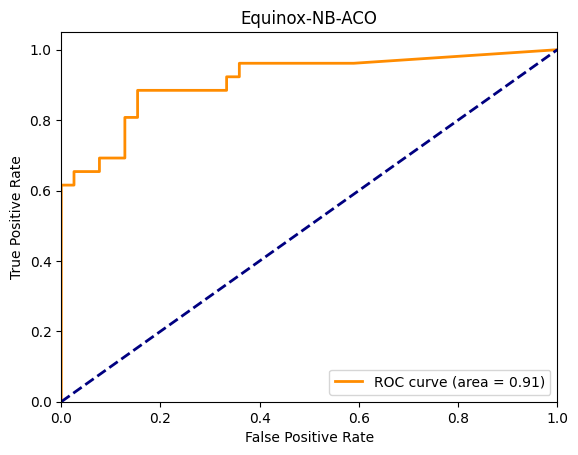

In [12]:
#Save AUC values
df = pd.DataFrame({
    'FPR': fpr,
    'TPR': tpr,
    'AUC': roc_auc
})
df.to_csv('./AUC_Extracts/Equinox/Equinox_NB_ACO.csv', index=False)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Equinox-NB-ACO')
plt.legend(loc="lower right")
plt.show()